## Preprocessing and data augmentations ##

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import cv2

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

# PyTorch
import torch

# Albumentations library
import albumentations as alb

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.imageproc import ImageData
from dentexmodel.torchdataset import load_and_process_image

print(f'Project module version: {dm.__version__}')

Project module version: 0.0.post1.dev157+g46b01a6.d20240222


In [2]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache() 
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA GeForce RTX 3070 Laptop GPU
CUDNN version:         8902

Device for model training/inference: cuda:0


In [3]:
# Path settings 
dentex_dir = os.path.join(os.environ['HOME'], 'data', 'dentex')
model_dir = os.path.join(os.environ['HOME'], 'data', 'model')
data_dir = os.path.join(dentex_dir, 'dentex_classification')
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays', 'crop')
data_file_name = 'dentex_disease_datasplit.parquet'
data_file = os.path.join(data_dir, data_file_name)

In [4]:
# Load the data frame with image paths
data_df = pd.read_parquet(data_file)
display(data_df.head(2))

,image_id,file_name,image_number,file_path,quadrant,position,label,cl,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset
0,272,train_191.png,191,/app/data/dentex/dentex_classification/quadran...,1,8,Impacted,0,39275,"[677.0, 446.0, 276.0, 207.0]",train_191_1435_1_8,9,/app/data/dentex/dentex_classification/quadran...,276,207,train
1,600,train_418.png,418,/app/data/dentex/dentex_classification/quadran...,1,7,Caries,1,34312,"[790.2912621359224, 372.81553398058253, 141.74...",train_418_3035_1_7,9,/app/data/dentex/dentex_classification/quadran...,142,310,train


### Preprocessing of the images ###

All of the images have different sizes. For the model we need all images to be the same shape. It is not always a good idea to change the aspect ratio of the images and we also want to keep the size of the teeth relative to the whole image size.
This is the process:
1. Find the largest image dimension and size S for that dimension in the entire data set
2. Scale all smaller images (with original aspect ration maintained) so that their largest dimension is S
3. Pad the smaller dimension to get square images
4. Scale the square image to the input size of the model

In [5]:
# We have the images sizes in the data frame
# Finding the largest image and its dimensions is easy
im_max_width = data_df['im_width'].max()
im_max_height = data_df['im_height'].max()
print(f'Maximum image width across the data set:  {im_max_width}')
print(f'Maximum image height across the data set: {im_max_height}')
# Set the maximum image size for all images
im_max_size = int(np.max((im_max_width, im_max_height)))
print(f'Maximum image size: {im_max_size}')

Maximum image width across the data set:  363
Maximum image height across the data set: 539
Maximum image size: 539


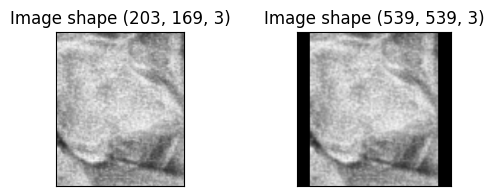

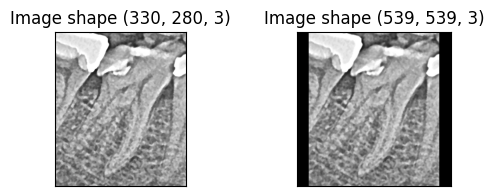

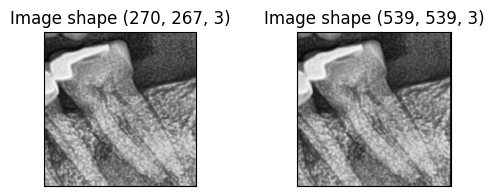

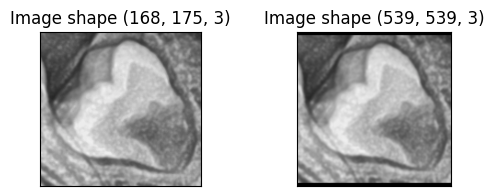

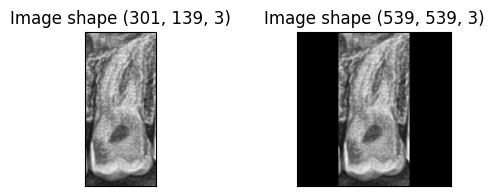

In [6]:
# Take a look at a few images
np.random.seed(234)
image_list = np.random.choice(data_df['box_name'].unique(), size=5, replace=False)
for i, image in enumerate(image_list):
    # Load the image
    image_file = os.path.join(image_dir, f'{image}.png')
    im = ImageData().load_image(image_file)
    # Pre-process the image
    im_processed = load_and_process_image(image_file_path=image_file,
                                          max_image_size=im_max_size)
    # Show the two images side-by-side
    im_list = [im, im_processed]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))
    for a, axa in enumerate(ax):
        axa.imshow(im_list[a])
        axa.set_title(f'Image shape {im_list[a].shape}')
        axa.set(xticks=[], yticks=[])
    plt.show()

### Run some example augmentations ###

In [7]:
# This is the input size for the model
im_size = 512
# Here is a list of example augmentations
# A complete list of pixel-level transformations is here
# https://github.com/albumentations-team/albumentations#pixel-level-transforms
train_aug = alb.Compose([
    alb.Resize(im_size + 32, im_size + 32),
    alb.RandomCrop(im_size, im_size),
    alb.HorizontalFlip(),
    alb.ShiftScaleRotate(),
    alb.Blur(),
    alb.RandomGamma(),
    alb.Sharpen(),
    alb.GaussNoise(),
    alb.CoarseDropout(16, 32, 32),
    alb.CLAHE()])
# Set the number of random transformations
n_transforms = 15

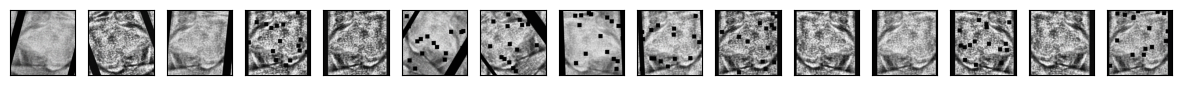

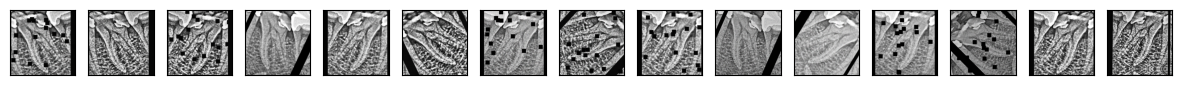

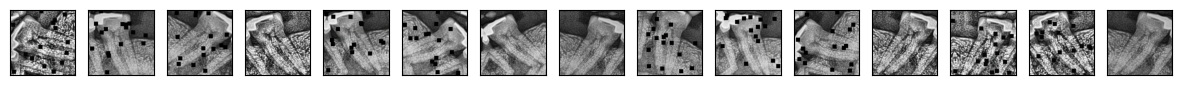

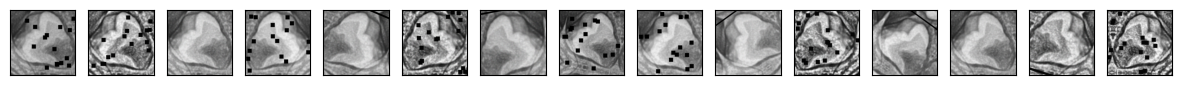

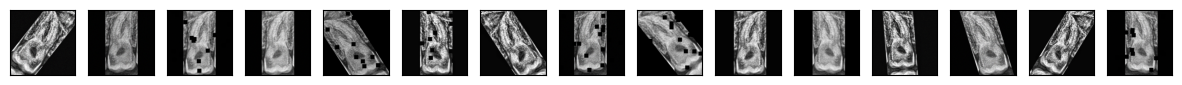

In [8]:
figsize = (15, 15)
for image in image_list:
    image_file = os.path.join(image_dir, f'{image}.png')
    im = load_and_process_image(image_file_path=image_file, max_image_size=im_max_size)
    fig, ax = plt.subplots(nrows=1, ncols=n_transforms, figsize=figsize)
    for n in range(n_transforms):
        im_aug = train_aug(image=im)['image']
        ax[n].imshow(im_aug)
        ax[n].set(xticks=[], yticks=[])
    plt.show()